# Применение метода фрактальной сигнатуры

Источники:

- [Довольно понятно объяснено, что мы делаем, и что это за "покрывала"](https://www.researchgate.net/publication/259695438_Application_of_the_Modified_Fractal_Signature_Method_for_Terrain_Classification_from_Synthetic_Aperture_Radar_Images)
- [Статья от Ампиловой](https://drive.google.com/open?id=1_gSwKN7Gt_i2qTQ9ThOgkzglllp6Tq-H)

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from scipy.ndimage import generic_filter

Загружаем картинку

Можно любую свою, только надо, чтобы она была в Gray scale, i guess

In [4]:
im = Image.open(BytesIO(requests.get('http://creativeskillset.org/assets/0000/1452/Anthophyllite-Asbestos-Scanning-Electron-Microscopy-Asbestos-Hunter_square.jpg?1394979307').content))

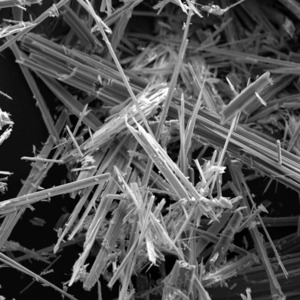

In [5]:
im

In [6]:
imar = np.array(im, dtype=np.int16)

In [12]:
imar.shape

(300, 300)

In [ ]:
imar[0:100]
imar[]

In [11]:
imar[::2]

array([[203, 201, 198, ...,  20,  14,  13],
       [ 94,  92,  90, ...,  57,  40,  31],
       [ 81,  84,  81, ...,  79,  73,  68],
       ...,
       [  8,   7,   5, ...,  39,  36,  34],
       [178, 175, 144, ...,  19,  20,  21],
       [145, 168, 180, ...,  26,  28,  29]], dtype=int16)

In [18]:
from scipy.ndimage.filters import maximum_filter, minimum_filter, generic_filter

Начинаем с того, что:
- $\delta = [1, d] -$по факту, просто шаг
- $u_0 = b_0 = $исходной марице

Вот хорошая иллюстрация одеяла, которое мы строим. Картинку спер из первой статьи

![blanket](images/blanket.png)

Вот, что надо посчитать итеративно:

$$u_{\delta}(i, j) = max\{u_{\delta - 1}(i, j) + 1, \underset{|(m,n) - (x,y)| \le 1}{max} u_{\delta-1}(m,n) \}$$

$$b_{\delta}(i, j) = min\{b_{\delta - 1}(i, j) - 1, \underset{|(m,n) - (x,y)| \le 1}{min} b_{\delta-1}(m,n) \}$$

В результате, можно посчитать объем на шаге $\delta$ следующим образом:

$$Vol_{\delta} = \sum (u_{\delta}(i, j) - b_{\delta}(i, j))$$

## Говнокодерский способ

In [7]:
%%time
u = imar.copy()
b = imar.copy()

ds = range(1, 5)
vols = []

for d in ds:
    un = u.copy()
    bn = b.copy()
    
    u_dd = np.pad(u, 1, 'constant', constant_values=0)
    b_dd = np.pad(b, 1, 'constant', constant_values=255)
    
    for i in range(1, imar.shape[0]+1):
        for j in range(1, imar.shape[1]+1):
            
            u_dp1 = np.max([           u_dd[i, j-1],
                            u_dd[i-1, j], u_dd[i, j] + 1, u_dd[i+1, j],
                                       u_dd[i, j+1]
                           ])
            b_dm1 = np.min([           b_dd[i, j-1],
                            b_dd[i-1, j], b_dd[i, j] - 1, b_dd[i+1, j],
                                       b_dd[i, j+1]
                           ])
            

            un[i-1, j-1] = u_dp1
            bn[i-1, j-1] = b_dm1
            
    
    u = un
    b = bn
    vols.append(np.sum(u - b))

CPU times: user 20.1 s, sys: 257 ms, total: 20.4 s
Wall time: 20.6 s


In [8]:
vols

[3101334, 5390750, 7150232, 8580587]

## Реализация через векторизацию

In [48]:
%%time
u = imar.copy()
b = imar.copy()

footprint=np.array([[0, 1, 0],
                    [1, 0, 1],
                    [0, 1, 0]])
ds = range(4, 30)
vols = []

for d in ds:
    fst_u = u + 1
    fst_b = b - 1

    scnd_u = maximum_filter(u, mode='constant', footprint=footprint, cval=0)
    scnd_b = minimum_filter(b, mode='constant', footprint=footprint, cval=255)

    u = np.maximum(fst_u, scnd_u)
    b = np.minimum(fst_b, scnd_b)
    
    vols.append(np.sum(u - b))

CPU times: user 352 ms, sys: 5.46 ms, total: 357 ms
Wall time: 360 ms


In [13]:
vols

[3101334, 5390750, 7150232, 8580587]

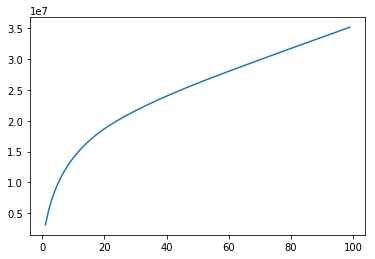

In [49]:
plt.plot(ds, vols)

# Зависимость объема от $\epsilon$

In [13]:
def fractal_signature(imar, d_=10):
    u = imar.copy()
    b = imar.copy()

    footprint=np.array([[0, 1, 0],
                        [1, 0, 1],
                        [0, 1, 0]])
    ds = range(1, d_)
    vols = []

    for d in ds:
        fst_u = u + 1
        fst_b = b - 1

        scnd_u = maximum_filter(u, mode='constant', footprint=footprint, cval=0)
        scnd_b = minimum_filter(b, mode='constant', footprint=footprint, cval=255)

        u = np.maximum(fst_u, scnd_u)
        b = np.minimum(fst_b, scnd_b)

        vols.append(np.sum(u - b))
    return (vols[-1] - vols[-2]) / 2

In [18]:
fractal_signature(imar, 10)

370530.0

In [51]:
ass_d300

array([], dtype=float64)

In [14]:
eps = 100

0 100
0 100


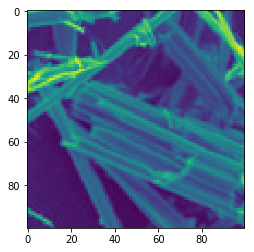

0 100
100 200


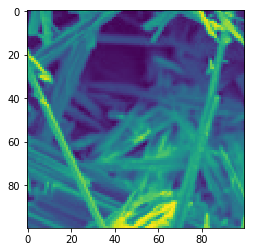

100 200
0 100


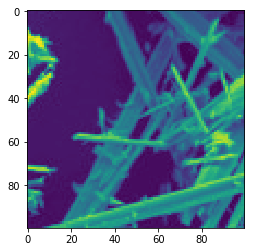

100 200
100 200


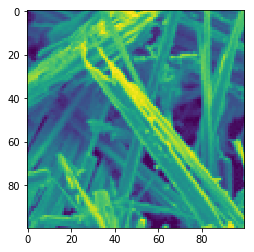

In [16]:
for start1, end1 in zip(range(0, imar.shape[0]-eps, eps), range(eps, imar.shape[0], eps)):
    for start2, end2 in zip(range(0, imar.shape[1]-eps, eps), range(eps, imar.shape[1], eps)):
        print(start1, end1)
        print(start2, end2)
        plt.imshow(imar[start1:end1, start2:end2])
        plt.show()

In [21]:
from progressbar import ProgressBar

In [36]:
ass_d4 = []
ass_d10 = []
ass_d20 = []
ass_d50 = []
ass_d300 = []
epses = range(4, 30)

for eps in epses:
    ads4 = ads10 = ads20 = ads50 = ads300 = 0
    bar = ProgressBar()
    for start1, end1 in bar(zip(range(0, imar.shape[0]-eps, eps), range(eps, imar.shape[0], eps))):
        for start2, end2 in zip(range(0, imar.shape[1]-eps, eps), range(eps, imar.shape[1], eps)):
#             ads4 += fractal_signature(imar[start1:end1, start2:end2], 4)
#             ads10 += fractal_signature(imar[start1:end1, start2:end2], 10)
#             ads20 += fractal_signature(imar[start1:end1, start2:end2], 20)
            ads50 += fractal_signature(imar[start1:end1, start2:end2], 20)
#             ads300 += fractal_signature(imar[start1:end1, start2:end2], 300)
#     ass_d4.append(ads4)
#     ass_d10.append(ads10)
#     ass_d20.append(ads20)
    ass_d50.append(ads50)
#     ass_d300.append(ads300)

| |                                      #           | 73 Elapsed Time: 0:00:13
| |         #                                        | 58 Elapsed Time: 0:00:09
| |                                     #            | 48 Elapsed Time: 0:00:06
| |                                             #    | 41 Elapsed Time: 0:00:04
| |                                    #             | 36 Elapsed Time: 0:00:03
| |                            #                     | 32 Elapsed Time: 0:00:02
| |                      #                           | 28 Elapsed Time: 0:00:02
| |                    #                             | 26 Elapsed Time: 0:00:02
| |               #                                  | 23 Elapsed Time: 0:00:01
| |              #                                   | 22 Elapsed Time: 0:00:01
| |           #                                      | 20 Elapsed Time: 0:00:01
| |        #                                         | 18 Elapsed Time: 0:00:00
| |       #                             

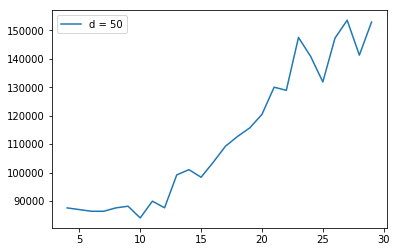

In [37]:
# plt.plot(epses, ass_d4, label="d = 4")
# plt.plot(epses, ass_d10, label="d = 10")
# plt.plot(epses, ass_d20, label="d = 20")
plt.plot(epses, ass_d50, label="d = 50")
# plt.plot(range(4, 30), ass_d300, label="d = 300")
plt.legend()